<h2><center>Starship Detection</center></h2>

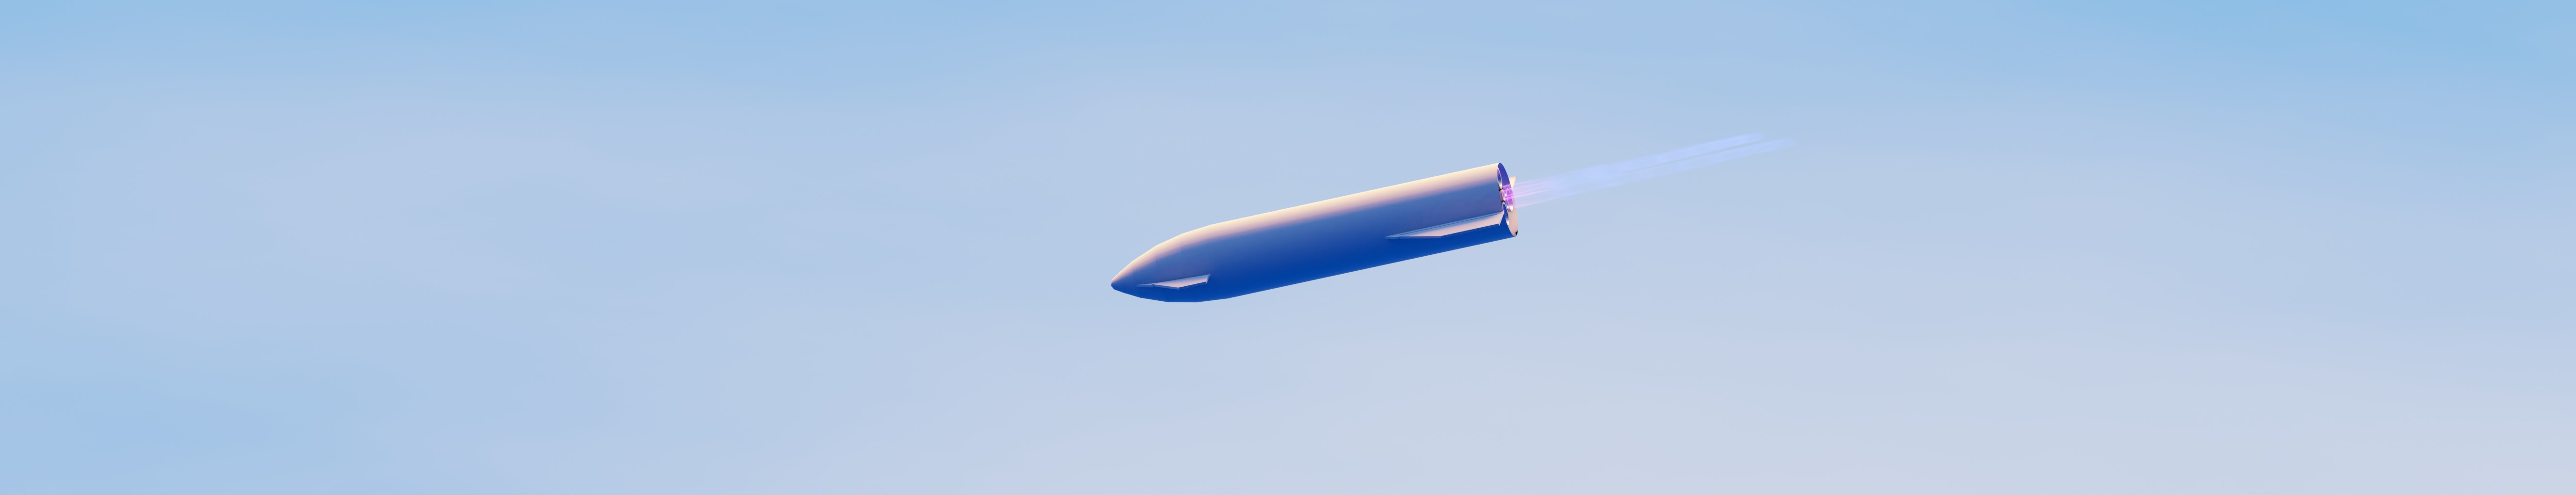

# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

In [ ]:
%aicrowd login --api-key API_KEY

In [ ]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c starship-detection -o data

In [ ]:
!unzip data/data.zip -d /content/images >> /dev/null

In [ ]:
!pip uninstall scikit-image -y
!pip install scikit-image

# Importing Libraries

In [ ]:
# Image Reading & Preprocessing
import skimage.io
import matplotlib.pyplot as plt
import numpy as np

# Misc.
import pandas as pd
from tqdm.notebook import tqdm
import os
from natsort import natsorted
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.draw import rectangle
from skimage.measure import find_contours

# Submitting Results 📄

In [ ]:
# Getting all the testing images 
test_imgs = natsorted(os.listdir("images"))
print(len(test_imgs))

In [ ]:
# Function to generate the bounding boxes
def gen_bounding_boxes(img):

  # Converting the image to numpy array 
  gray = rgb2gray(img)
  result = sobel(gray)

  contours = find_contours(result, 0.05)

  def get_bounding_rect(contour):
    x_min = np.min(contour[:, 0])
    x_max = np.max(contour[:, 0])
    y_min = np.min(contour[:, 1])
    y_max = np.max(contour[:, 1])
    return round(x_min), round(y_min), round(x_max), round(y_max)

  def draw_rect(img, points, color=[255, 0, 0]):
    # Make sure the coordinates are expressed as integers
    rr, cc = rectangle(start=points[:2], end=points[2:])
    img[rr, cc] = color
    return img

  x_min = 512
  y_min = 512
  x_max = 0
  y_max = 0
  draw_img = img.copy()
  for contour in contours:
    points = get_bounding_rect(contour)
    x_min = min(x_min, points[0])
    y_min = min(y_min, points[1])
    x_max = max(x_max, points[2])
    y_max = max(y_max, points[3])

  return y_min, x_min, y_max - y_min, x_max - x_min

In [ ]:
bboxes = []
image_ids = []

# Ground through each test image
for img_name in tqdm(test_imgs):

  # Reading the test image
  img = skimage.io.imread(os.path.join("images", img_name))

  # Generating the bounding boxes
  x,y,w,h = gen_bounding_boxes(img)

  # Adding the boundong boxes and image id
  bboxes.append([x,y,w,h])
  image_ids.append(int(img_name.split(".")[0]))

In [ ]:
fill = False
xs = []
ys = []
ws = []
hs = []
missing_idxes = []
for idx, bbox in enumerate(bboxes):
  x, y, w, h = bbox
  if x == 512 or x == 0 or y == 512 or y == 0 or w <=0 or h <= 0:
    print(idx)
    missing_idxes.append(idx)
  else:
    xs.append(x)
    ys.append(y)
    ws.append(w)
    hs.append(h)
if fill:
  x_mean = sum(xs) / len(xs)
  y_mean = sum(ys) / len(ys)
  w_mean = sum(ws) / len(ws)
  h_mean = sum(hs) / len(hs)
  for idx in missing_idxes:
    bboxes[idx] = [x_mean, y_mean, w_mean, h_mean]

In [ ]:
def merge_boxes(boxes):
  xs = []
  ys = []
  ws = []
  hs = []
  for box in boxes:
    x, y, w, h = box
    xs.append(x)
    ys.append(y)
    ws.append(w)
    hs.append(h)
  return sum(xs) / len(xs), sum(ys) / len(ys), sum(ws) / len(ws), sum(hs) / len(hs)

In [ ]:
# Adding the image id and bounding boxes to a dataframe
df = pd.DataFrame({"ImageID":image_ids, "bbox":bboxes})
df = df.sort_values("ImageID").reset_index(drop=True)
df

In [ ]:
!rm -rf assets
!mkdir assets

df.to_csv(os.path.join("assets", "submission.csv"), index=False)

**Note : Please make sure that there should be filename `submission.csv` in `assets` folder before submitting it**

## Uploading the Results